# Random Projections

This notebook will walk through a toy example of random projections, explain how they can be used for approximate K-nearest neighbors searches, and look at the speed/accuracy tradeoffs involved.

First, some convenience functions for producing batches of N-dimensional vectors on the unit sphere.

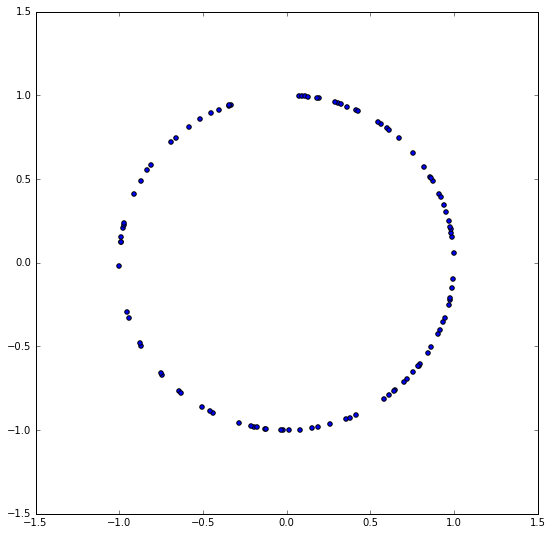

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from __future__ import print_function, division
import matplotlib

matplotlib.rcParams['figure.figsize'] = (9.0, 9.0)

random = np.random.RandomState(seed=1)

def batch_unit_norm(b, epsilon=1e-8):
    """
    Give all vectors unit norm along the last dimension
    """
    return b / np.linalg.norm(b, axis=-1, keepdims=True) + epsilon

def unit_vectors(n_examples, n_dims):
    """
    Create n_examples of synthetic data on the unit 
    sphere in n_dims
    """
    dense = random.normal(0, 1, (n_examples, n_dims))
    return batch_unit_norm(dense)

toy_dims = 2
toy_examples = 100
toy_dense = unit_vectors(toy_examples, toy_dims)

plt.scatter(toy_dense[:, 0], toy_dense[:, 1])

# Hyperplanes for Dividing the Space

A hyperplane is a plane whose dimension is one less than the ambient space.  We can approximate the location of points by slicing it up using N of these hyperplanes.

In the case where our data points all fall on the unit sphere, it makes sense for our hyperplanes to all pass through the origin, so we can define them with a single point in N-dimensional space that is perpindicular to the plane.

In [2]:
def hyperplanes(n_planes, n_dims):
    """
    Return n_planes plane vectors, which describe
    hyperplanes in n_dims space that are perpendicular
    to lines running from the origin to each point
    """
    return unit_vectors(n_planes, n_dims)

In [3]:
def random_projection(plane_vectors, data, pack=True, binarize=True):
    """
    Return bit strings for a batch of vectors, with each 
    bit representing which side of each hyperplane the point
    falls on
    """
    
    flattened = data.reshape((len(data), -1))
    x = np.dot(plane_vectors, flattened.T).T
    if not binarize:
        return x
    
    output = np.zeros((len(data), len(plane_vectors)), dtype=np.uint8)
    output[np.where(x > 0)] = 1
    
    if pack:
        output = np.packbits(output, axis=-1).view(np.uint64)
    
    return output

In [4]:
def orthogonal_vectors(x):
    """
    Given a batch of unit-norm vectors, return
    a batch of vectors that are orthogonal to each
    one
    """
    r = unit_vectors(*x.shape)
    r -= (r * x).sum(axis=-1, keepdims=True) * x
    r = batch_unit_norm(r)
    return r

-0.45320958947679657


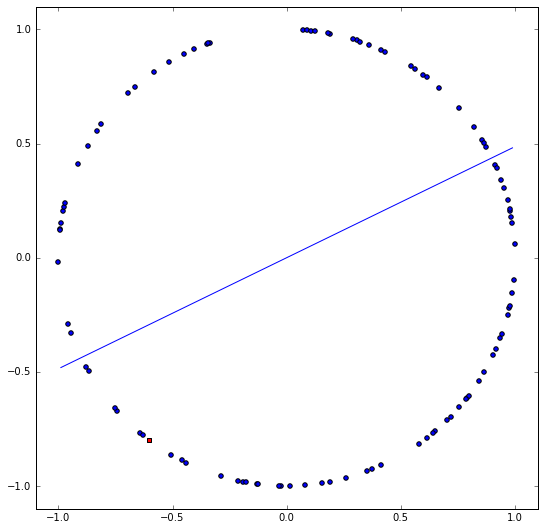

In [5]:
from scipy.spatial.distance import cosine

planes = hyperplanes(1, toy_dims)
orth = orthogonal_vectors(planes) * 1.1

plt.scatter(toy_dense[:, 0], toy_dense[:, 1])
for o in orth:
    plt.plot([o[0], -o[0]], [o[1], -o[-1]])

vec = unit_vectors(1, toy_dims)
plt.scatter(vec[:, 0], vec[:, 1], c='red', marker='s')

print(np.dot(planes.squeeze(), vec.squeeze()))

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.show()

# From Hyperplanes to Bit Vectors

We can charaterize each data point with a bit vector, one bit for each hyperplane, that is on or off depending on which side of each hyperplane the data point falls.

This makes very fast brute force searches possible, by using processor instructions for bitwise XOR and then bit counting to compute the hamming distance between a query and all examples in the index

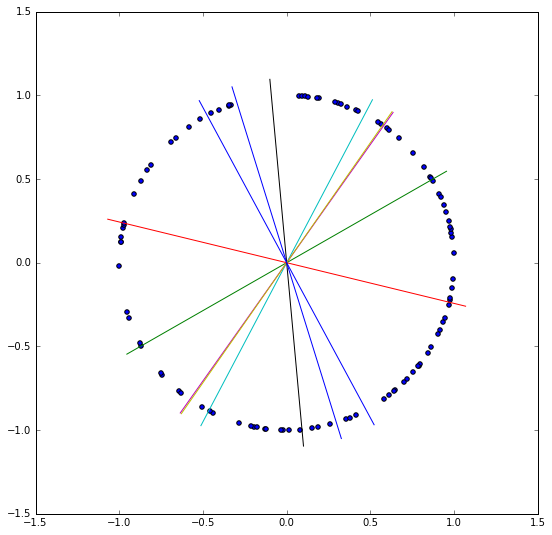

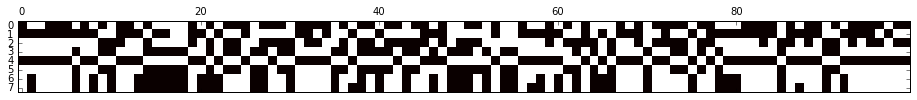

In [6]:
planes = hyperplanes(8, toy_dims)
orth = orthogonal_vectors(planes) * 1.1

plt.scatter(toy_dense[:, 0], toy_dense[:, 1])
for o in orth:
    plt.plot([o[0], -o[0]], [o[1], -o[-1]])

projection = random_projection(planes, toy_dense, pack=False)
plt.matshow(projection.T, cmap='hot')

# A More Realistic Example

Now that we understand the basics, we'll work with a more realistic example featuring:

- 500K data points (~100 hours of audio given our embedding scheme)
- 128-dimensional embedding vectors

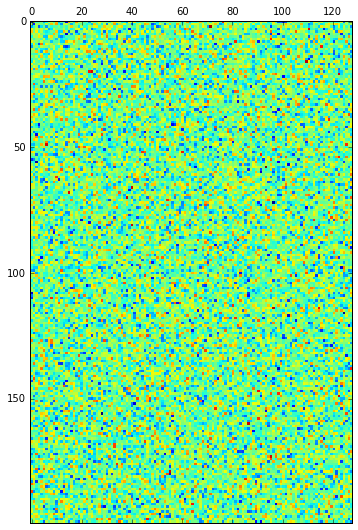

In [7]:
# this represents ~100 hours of audio
n_examples = int(5e5)
n_dims = 128
dense = unit_vectors(n_examples, n_dims)
plt.matshow(dense[:200])

In [140]:
from scipy.spatial.distance import cdist, cosine
import heapq


class HyperPlaneNode(object):
    
    def __init__(self, data, smallest_node):
        super(HyperPlaneNode, self).__init__()
        
        # stop subdividing at this point
        self.smallest_node = smallest_node
        
        self.dimensions = data['vectors'].shape[-1]

        # copy this data, so we're not hanging on to the
        # vector data unnecessarily
        self.data = data['indices'].copy()
        
        # choose one plane, at random, for this node
        self.plane = hyperplanes(1, data['vectors'].shape[-1])

        if len(data) <= smallest_node:
            self.left = None
            self.right = None
        else:
            # determine which side of the plane each data point lies
            x = random_projection(self.plane, data['vectors'], pack=False).squeeze()
            self.left = HyperPlaneNode(data[x == 1], smallest_node)
            self.right = HyperPlaneNode(data[x == 0], smallest_node)
    
    def __repr__(self):
        return 'Node(n_items={n_items}, is_leaf={is_leaf})'\
            .format(n_items=len(self), is_leaf=self.is_leaf)
    
    def __str__(self):
        return self.__repr__()
    
    def __len__(self):
        return len(self.data)
    
    @property
    def is_leaf(self):
        return self.left is None and self.right is None
            

# TODO: in order to implement the priority queue, compute the angle between 
# the query and a vector orthogonal to the node's hyperplane vector 
# (this indicates where the hyperplane will cross the unit sphere)


class MultiHyperPlaneTree(object):
    def __init__(self, data, smallest_node, n_trees=10):
        super(MultiHyperPlaneTree, self).__init__()
        self.dimensions = data.shape[1]
        records = np.recarray(
            shape=(len(data),), 
            dtype=[('indices', np.uint64), ('vectors', np.float32, (data.shape[1],))])
        records['indices'] = np.arange(0, len(data), dtype=np.uint64)
        records['vectors'] = data
        self.records = records
        
        self.roots = [HyperPlaneNode(records, smallest_node) for _ in xrange(n_trees)]
    
    def search_with_priority_queue(self, query, n_results, threshold):
        query = query.reshape(1, self.dimensions)
        
        indices = set()
        
        # this is kinda arbitrary.  
        # How do I pick this intelligently?
        to_consider = n_results * 100
        
        # put the root nodes in the queue
        heap = [(-9999, root) for root in self.roots]
        
        # traverse the tree, finding candidate indices
        while heap and len(indices) < to_consider:
            current_distance, current_node = heapq.heappop(heap)
            
            if current_node.is_leaf:
                indices.update(current_node.data)
                continue
            
            # find the angle between the query and the point where the hyperplane intersects
            # the unit sphere
            dist = random_projection(
                current_node.plane, query, pack=False, binarize=False).squeeze()
            abs_dist = np.abs(dist)
            
            if abs_dist < threshold:
                heapq.heappush(heap, (-abs_dist, current_node.left))
                heapq.heappush(heap, (-abs_dist, current_node.right))
            elif np.sign(dist) == 1:
                heapq.heappush(heap, (-abs_dist, current_node.left))
            else:
                heapq.heappush(heap, (-abs_dist, current_node.right))
    
        indices = np.array(list(indices), dtype=np.uint64)
        
        # TODO: Consider using argpartition here
        data = self.records['vectors'][indices]
        dist = cdist(query, data, metric='cosine').squeeze()
        srt_indices = np.argsort(dist)[:n_results]
        return indices[srt_indices]

# Search Types

We'll measure the performance and accuracy of three different types of search:

- brute force cosine distance search in the 128-dimensional space (accuracy will always be perfect since this is our ground truth)
- bitwise hamming distance using only our random projection
- A hybrid approach, where we use the random projection to narrow the result set, and then use a brute-force cosine distance search on the subset

In [141]:
from zounds.nputil import packed_hamming_distance


def base_search(data, n_results, dist):
    partitioned_indices = np.argpartition(dist, n_results)[:n_results]
    sorted_indices = np.argsort(dist[partitioned_indices])
    indices = partitioned_indices[sorted_indices]
    return indices

def brute_force_search(query, data, n_results):
    """
    Perform a brute-force cosine distance search
    """
    dist = cdist(query[None, :], data, metric='cosine').squeeze()
    return base_search(data, n_results, dist)

def hamming_distance_search(query, data, n_results):
    """
    Perform a search using only the random projection
    onto bit strings
    """
    dist = packed_hamming_distance(query, data)
    return base_search(data, n_results, dist)

def hybrid_search(query, data, n_results, factor=100):
    """
    Perform a hybrid search, that uses the bit string index
    to narrow the result set, after which a brute-force search
    over the subset is performed
    """
    query, bit_query = query
    data, bit_index = data
    
    indices = hamming_distance_search(bit_query, bit_index, n_results * factor)
    brute_force_indices = brute_force_search(query, data[indices], n_results)
    return indices[brute_force_indices]


log_index = MultiHyperPlaneTree(dense, smallest_node=1024, n_trees=8)



def tree_search(query, data, n_results):
    return log_index.search_with_priority_queue(query, n_results, threshold=0.0001)

In [142]:
query = unit_vectors(1, n_dims).squeeze()
bf_indices = brute_force_search(query, dense, 50)
t_indices = log_index.search_with_priority_queue(query, 50, threshold=0.02)
print(bf_indices)
print(t_indices)
print(len(set(bf_indices) & set(t_indices)))
print(set(bf_indices) & set(t_indices))

[309800 369318 461295 495735 265548 460470 376790 296188  16248 448593
 395362 365153 230906 106952 324927  52081  21804 446430  97726 120079
 359438  78099  22490  64584  47131  92870 111800 110885 169123 228754
 269974 442995 287810 372416 420429 438434  57209 215169 445645 137329
  27738  53853 454706 359724 331039 229605 181338 472370 450981 183013]
[265548  52081  47131  57209 148082  81317  19894 428599  68418 231534
 141922  88877  56161 124970 417923 480135 166884 131278  66624 385039
 328298 201823 392327 332020  27579 124992 488138 305766   6567 104795
  74212  63862  34627 214569 299203  67563 433075 113390 367519 160795
  10457 445376 377540 134240 196450  42550  49495  98933 479503  92711]
4
set([52081, 47131, 265548, 57209])


# The Experiment

We'll run an experiment for each approach, measuring the speed and accuracy of each approach over 100 searches, with a search result set size of 50.

In [143]:
from time import time

def experiment(
        data, 
        queries, 
        n_search_results,
        search_func,
        reference_indices=None):
    
    """
    Measure the performance of various search, both
    in terms of speed and accuracy, given reference indices
    that determine the "correct" answer to queries given the
    input data
    """
    
    if reference_indices is None:
        reference_indices = [None] * len(queries)
    
    timings = []
    accuracy = []
    results = []
    
    for query, reference in zip(queries, reference_indices):
        start = time()
        indices = search_func(query, data, n_search_results)
        timings.append(time() - start)
        results.append(indices)
        
        if reference is None:
            continue
        
        intersection = set(indices) & set(reference)
        accuracy.append(len(intersection) / n_search_results)
    
    mean_timings = np.mean(timings)
    mean_accuracy = np.mean(accuracy) if len(accuracy) else 1.0
    results = np.array(results)
    
    return mean_timings, mean_accuracy, results

In [144]:
n_search_results = 50
iterations = 100
queries = unit_vectors(iterations, n_dims)

# measure the performance of the brute-force search
bf_time, bf_accuracy, bf_results = experiment(
    dense, 
    queries, 
    n_search_results, 
    brute_force_search)
print('brute force test complete')
print(bf_time, bf_accuracy)

# measure the performance of the tree search
t_time, t_accuracy, _ = experiment(
    dense,
    queries,
    n_search_results,
    tree_search,
    reference_indices=bf_results)
print('tree test complete')
print(t_time, t_accuracy)

# define the different bit or plane counts we'd like
# to experiment with
bit_counts = [64, 128, 256, 512]

rp_results = []
hybrid_results = []

for bit_count in bit_counts:
    
    plane_vectors = hyperplanes(bit_count, n_dims)
    bit_index = random_projection(plane_vectors, dense)    
    bit_queries = random_projection(plane_vectors, queries)

    # measure the speed and accuracy of the pure random projection
    # search using bitwise hamming distance
    rp_time, rp_accuracy, _ = experiment(
        bit_index, 
        bit_queries, 
        n_search_results, 
        hamming_distance_search, 
        reference_indices=bf_results)
    rp_results.append((rp_time, rp_accuracy))
    print('pure random projection with {bit_count} bits complete'.format(**locals()))
    print(rp_time, rp_accuracy)
    
    # measure the speed and accuracy of the hybrid approach, 
    # which narrows the results on which to use the brute-force
    # approach using the random projection index
    hybrid_queries = [(q, bq) for q, bq in zip(queries, bit_queries)]
    hybrid_time, hybrid_accuracy, _ = experiment(
        (dense, bit_index),
        hybrid_queries,
        n_search_results,
        hybrid_search,
        reference_indices=bf_results)
    hybrid_results.append((hybrid_time, hybrid_accuracy))
    print('hybrid random projection with {bit_count} bits complete'.format(**locals()))
    print(hybrid_time, hybrid_accuracy)

brute force test complete
0.07276335716247559 1.0
tree test complete
0.003664360046386719 0.0676
pure random projection with 64 bits complete
0.004553744792938233 0.01
hybrid random projection with 64 bits complete
0.006852927207946777 0.22400000000000003
pure random projection with 128 bits complete
0.008109714984893799 0.031200000000000002
hybrid random projection with 128 bits complete
0.010205330848693848 0.39980000000000004
pure random projection with 256 bits complete
0.010034418106079102 0.0766
hybrid random projection with 256 bits complete
0.012146310806274414 0.657
pure random projection with 512 bits complete
0.01451803684234619 0.17480000000000004
hybrid random projection with 512 bits complete
0.016688342094421386 0.8918


# The Verdict

The random projections alone are very fast, allowing up to 200 queries-per-second, but never breaking 50% accuracy, even with 2048 hyperplanes (and hence, bits).

The hybrid approach has a sweet spot where we can do 50-90 queries per second, and get 70-95% accuracy.

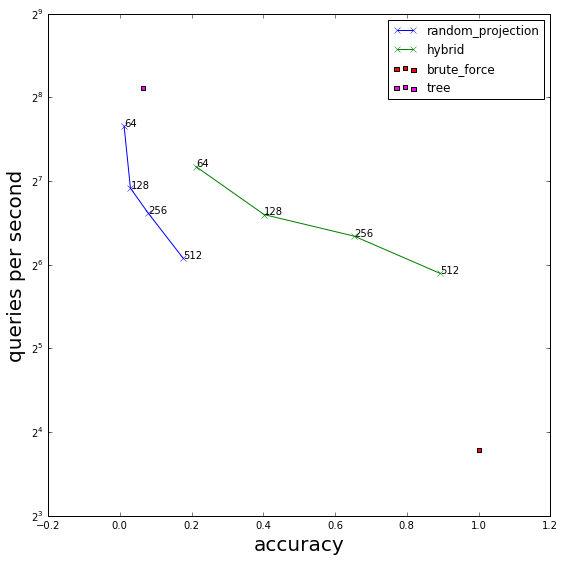

In [25]:
rp_results = np.array(rp_results)
hybrid_results = np.array(hybrid_results)

rp_results[:, 0] = 1.0 / rp_results[:, 0]
hybrid_results[:, 0] = 1.0 / hybrid_results[:, 0]


plt.scatter(
    bf_accuracy, 
    1.0 / bf_time, 
    c='red', 
    marker='s',
    label='brute_force')

plt.scatter(
    t_accuracy,
    1.0 / t_time,
    c='magenta',
    marker='s',
    label='tree')

plt.plot(
    rp_results[:, 1], 
    rp_results[:, 0], 
    marker='x', 
    label='random_projection')
for bit_count, result in zip(bit_counts, rp_results):
    plt.annotate(bit_count, xy=result[::-1], textcoords='data')

plt.plot(
    hybrid_results[:, 1], 
    hybrid_results[:, 0], 
    marker='x', 
    label='hybrid')
for bit_count, result in zip(bit_counts, hybrid_results):
    plt.annotate(bit_count, xy=result[::-1], textcoords='data')


plt.xlabel('accuracy', fontsize=20)
plt.ylabel('queries per second', fontsize=20)
plt.yscale('log', basey=2) 
plt.legend()
plt.show()